# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# LSTM

### Seperate static and dynamic

In [8]:
from keras.models import Sequential, Model
from keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    Masking,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf


def createModel2(timeSteps, timeFeatures):
    # time series layers
    timeInputLayer = Input(shape=(timeSteps, timeFeatures))
    # maskingLayer = Masking(mask_value=0.0)(timeInputLayer)
    # cnnLayer = Conv1D(64, 3, activation="relu", kernel_regularizer=l2(0.01))(maskingLayer)
    # batNormCnn = BatchNormalization()(cnnLayer)
    # poolingLayer = MaxPooling1D(2)(batNormCnn)
    seriesLayer = LSTM(64, return_sequences=True)(timeInputLayer)
    dropout1 = Dropout(0.2)(seriesLayer)
    seriesLayer2 = tf.keras.layers.GlobalAveragePooling1D()(dropout1)
    dense2 = Dense(1, activation="sigmoid")(seriesLayer2)

    model = Model(inputs=timeInputLayer, outputs=dense2)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

2024-08-29 00:20:19.382969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 00:20:19.390151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 00:20:19.396981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 00:20:19.399312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 00:20:19.405699: I tensorflow/core/platform/cpu_feature_guar

In [9]:
import pickle

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from utils.class_voter import combineProbas
from utils.prepare_data import (
    DeepLearningDataPreparer,
    normalizeData,
    patientsToNumpy,
    trainValTestPatients,
)
from constants import CATEGORICAL_MEASURES, TEMP_PATH
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


loses = []
aucs = []
accuracies = []
precisions = []
recals = []
train_loss_list = []
val_loss_list = []
models = []
for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        cacheFile = TEMP_PATH / f"dl_train_data/{i}_{ii}.pkl"
        cacheFile.parent.mkdir(parents=True, exist_ok=True)

        if cacheFile.exists():
            (
                (npTrainX, staticTrainX, trainY),
                (npValX, staticValX, valY),
                (npTestX, staticTestX, testY),
            ) = pickle.loads(cacheFile.read_bytes())
        else:
            npTrainX, staticTrainX, trainY = preparer.fit_transform(trainPatients)
            npValX, staticValX, valY = preparer.transform(valPatients)
            npTestX, staticTestX, testY = preparer.transform(testPatients)
            cacheFile.write_bytes(
                pickle.dumps(
                    (
                        (npTrainX, staticTrainX, trainY),
                        (npValX, staticValX, valY),
                        (npTestX, staticTestX, testY),
                    )
                )
            )

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        early_stopping = EarlyStopping(
            monitor="val_loss", patience=250, restore_best_weights=True
        )

        # expand static data to be time steps as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        model = createModel2(npTrainX.shape[1], npTrainX.shape[2])
        history = model.fit(
            npTrainX,
            np.array(trainY),
            epochs=5000,
            batch_size=32,
            validation_data=(npValX, np.array(valY)),
            class_weight=weight,
            callbacks=[early_stopping],
            verbose=0,
        )
        train_loss_list.append(history.history["loss"])
        val_loss_list.append(history.history["val_loss"])
        probas.append(model.predict(npTestX))
        model.save(f"result/lstm_only_model_{i}_{ii}.keras")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))

    finalAuc = roc_auc_score(testY, finalYProbas)
    aucs.append(finalAuc)

    y_pred = np.where(finalYProbas >= 0.5, 1, 0)

    accuracies.append(accuracy_score(testY, y_pred))
    precisions.append(precision_score(testY, y_pred))
    recals.append(recall_score(testY, y_pred))

I0000 00:00:1724865620.594451 1766812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865620.598410 1766812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865620.598496 1766812 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724865620.599662 1766812 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

2024-08-29 00:20:21.896256: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


In [10]:
# print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals))

AUCs: [0.833682190825048, 0.7951334379905809, 0.8276400208080458, 0.7987688572914861, 0.8086582367404285] 0.8127765487311178 0.01537806192772393
Accuracies: [0.7777777777777778, 0.7244444444444444, 0.76, 0.7377777777777778, 0.7633928571428571] 0.7526785714285714 0.019066037721735776
Precisions: [0.6428571428571429, 0.5930232558139535, 0.631578947368421, 0.6111111111111112, 0.6436781609195402] 0.6244497236140338 0.019621076309092215
Recals: [0.8076923076923077, 0.6538461538461539, 0.759493670886076, 0.6962025316455697, 0.717948717948718] 0.7270366764037651 0.05281851079590243


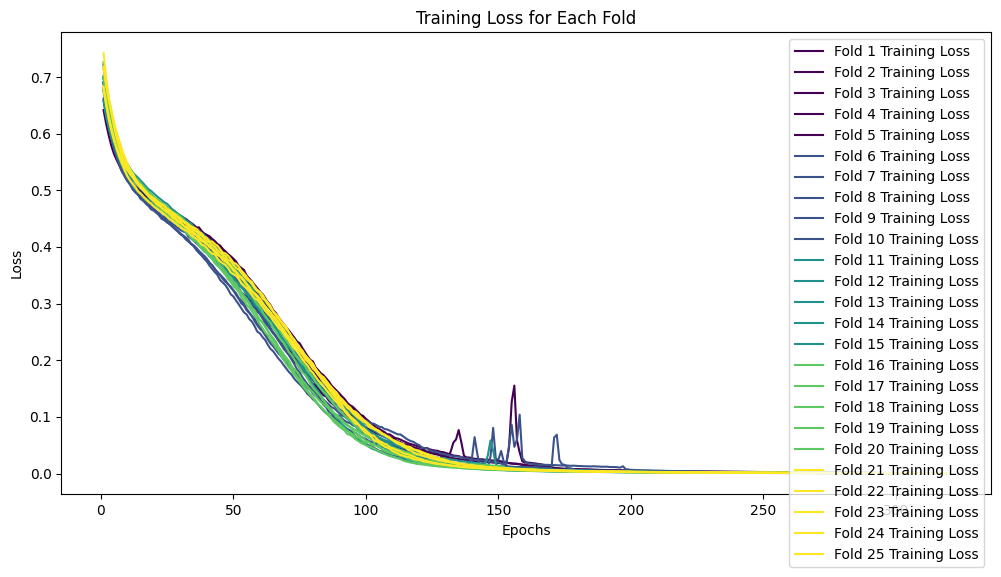

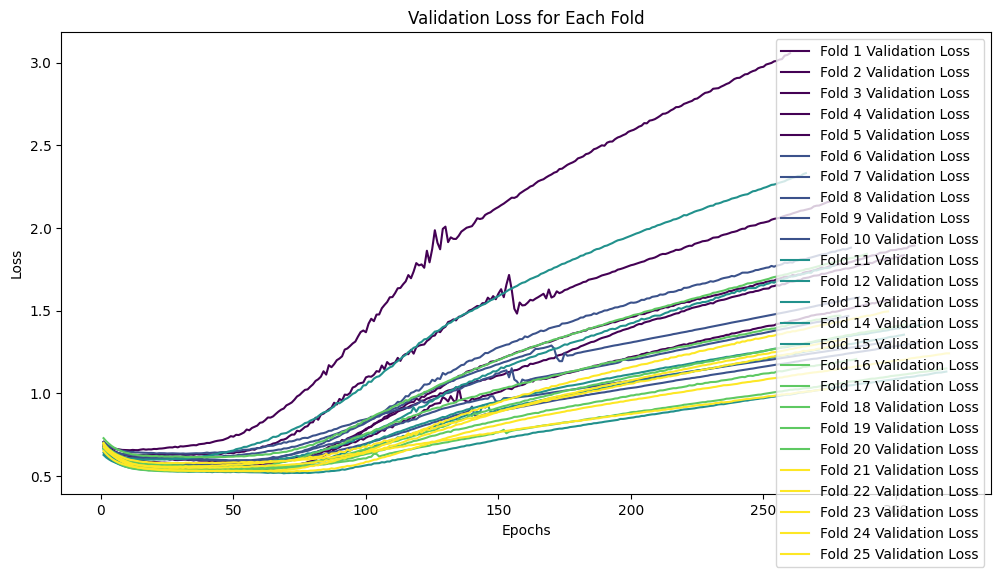

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()